# NEXTAI-MTL
# Technical Stream
# 2019 Cohort
# Tutorial : Recurrent neural networks (RNNs)
## Tutorial was adapted from this one (in french): 
https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/RNN/RNN_solutions.ipynb



## Autors

Francis Grégoire <francis.gregoire@rd.mila.quebec>

Jeremy Pinto <jeremy.pinto@rd.mila.quebec>

Jean-Philippe Reid <Jean-Philippe.Reid@ElementAI.com>

Mirko Bronzi <mirko.bronzi@mila.quebec>

### Translation to English: 

Laurent Charlin <lcharlin@gmail.com>

## Preface

This tutorial introduces the fundamental concepts that underlie recurrent neural networks (RNN et LSTM) using two example tasks.

The first task builds and compares an LSTM model to an RNN model.

In the second task, we exploit the properties of an LSTM by developping a neural language model to generate text. Through this example, you will learn how to preprocess text data to efficiently train a neural language model.

---
# Initialization 

To ensure that this tutorial runs properly on the Colab environment, we must install a few libraries using the `pip` utility. 

To begin, ensure that you are "connected" to the notebook ( check for "✓ CONNECTED" at the top right of your window). Then execute the cell below by selecting it and clicking `shift`+`Enter`. This can take a few minutes.

In [2]:
!pip3 install torch torchvision matplotlib

  Using cached https://files.pythonhosted.org/packages/5f/4a/f4eb1d57fa7db52298959ce38f27869dfe6bc75010048a64c5be94cbd33f/torch-1.0.1.post2-cp37-none-macosx_10_7_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/fb/01/03fd7e503c16b3dc262483e5555ad40974ab5da8b9879e164b56c1f4ef6f/torchvision-0.2.2.post3-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/2e/81/bb51214944e79f9c9261badd7ef99b573fb0bc9110c0075c6a9e76224d0d/matplotlib-3.0.3-cp37-cp37m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/c9/ed/27cc92e99b9ccaa0985a66133baeea7e8a3371d3c04cfa353aaa3b81aac1/Pillow-5.4.1-cp37-cp37m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/a6/6f/cb20ccd8f0f8581e0e090775c0e3c3e335b037818416e6fa945d924397d2/numpy-1.16.2-cp37-cp37m-macosx_10_6_intel.maco

In [3]:
import copy
import time
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset


use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")

# Setting the seed to a fixed value can be helpful in reproducing results
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

print("PyTorch version: ", torch.__version__)
print("GPU available: {}".format(use_gpu))

PyTorch version:  1.0.1.post2
GPU available: False


---
# Theoretical context


## Recurrent neural networks

Sequential data is ubiquituous and many tasks require it. Models of text data for tasks such as automatic translation, question answering, and dialogs are good examples. These model take into account the sequentiality (or temporality) of the data. That is, they model each word using its surrounding context (most often the words that appeared previously). 

Sequential data is challenging for multi-layer perceptrons because the data is typically not of fixed length (i.e., different text have different lengths). Further MLPs typically do not model the order of their inputs while the order of sequential data is very important.

Recurrent neural networks (RNNs) are models designed for such varying-length data. By varying length we mean that each example may have a different length (for example if each example is a sentence, then sentences could have different lengths). More formally, two sentences $\mathbf{s}_{i} = (x_{i,1}, \dots, x_{i,N})$ and $\mathbf{s}_{j} = (x_{j,1}, \dots, x_{j,M})$ are of different lengths if $N \neq M$. The hidden layer of an RNN  $\mathbf{h}_{t} \in \mathbb R^{d_{h}}$, also known as a recurrent state, is a $d_{h}$-dimensional vector which represents the memory of the network through time. At each time step $t$, the recurrent state is a recursive function which updates itself using the input variables $x_{t}$ and its recurrent state at the previous timestep $\mathbf{h}_{t-1}$. This function can be written down as

\begin{equation}
  \mathbf{h_{t}} = f(x_{t}, \mathbf{h}_{t-1}).
\end{equation}

It ensures that the output of the model at each timestep $t$ depends on the history (e.g., all inputs up to now). The function $f(\cdot)$ can be parametrized in various ways. For a vanilla RNN we use: 

\begin{equation}
  f(x_{t}, \mathbf{h}_{t-1}) = g(\mathbf{W}\psi(x_{t}) + \mathbf{U}\mathbf{h}_{t-1} + \mathbf{b}_{h}),
\end{equation}

where $\psi(x_{t})$ can be the identity function (this is what we will use in task 1) or a function which transforms a discrete variable into a continuous $d_{e}$-dimensional vectorial representation (this is what we will use in task 2). The $\mathbf{W} \in \mathbb R^{d_{h} \times d_{e}}$ and $\mathbf{U} \in \mathbb R^{d_{h} \times d_{h}}$ matrices are the shared parameters of the model. They are shared through all timesteps. (In other words we assume that the transition dynamics are static). These matrices encode how much importance to give to the current datum and to the previous recurrent state. Last, $g(\cdot)$ is a non-linear activation.

A schema of a basic RNN looks like this:

![alt-text](https://github.com/mila-iqia/dlschool-ivado-a19/blob/master/images/RNN-unrolled.png?raw=true)

The network's structure and the output $y$'s format are task-dependant. For modelling classification tasks where the output occurs at a single timestep (usually right after the last input) we typically use the vector representation of the last recurrent state. 

For binary classification problems  ($y \in \{0,1\}$), we use a $\sigma$ activation function which corresponds to a Bernoulli output. This output can be understood as predicting a normalized score sometimes referred to as the probability of the output taking the value 1: 

\begin{equation}
  p(y_{t} = 1 | \mathbf{h}_{t}) = \sigma(\mathbf{v}^\top \mathbf{h}_{t} + \mathbf{b}_{c}).
\end{equation}


For multi-class classification problems ($y \in \{0,1,2,\ldots,n\}$), the output layer contains $n$ neurons and we typically use a *softmax* activation function which returns normalized score over each possible class:

\begin{equation}
  [p(y_{t} = 1 | \mathbf{h}_{t}), \dots, p(y_{t} = n | \mathbf{h}_{t})]^\top = softmax(\mathbf{V}^\top \mathbf{h}_{t} + \mathbf{b}_{c}),
\end{equation}

where $\mathbf{V} \in \mathbb R^{d_{h} \times d_{y}}$, $\mathbf{v}\ \in \mathbb R^{d_{h}}$ et $\mathbf{b}_{c}\ \in \mathbb R^{d_{y}}$ are parameters of the model.

### Long-term dependencies
In theory, RNNs can model arbitrarily long dependencies in sequences. In practice, it was shown that it is difficult to learn long-term dependices using RNNs (see this [article from Bengio et al. (1994)](http://ai.dinfo.unifi.it/paolo/ps/tnn-94-gradient.pdf) for the details). The intuition is as follows. RNNs are recursive models and their parameters are shared through all timesteps (e.g., for a sequence of length 10, the same parameters will be used on the order of 10 times). Let us think of how the error calculated at the last step will be lead to an update at the first step. The gradient will have to flow back through each recurent state in reverse order. This sequence of operations involves a sequence of multiplications (through the chain rule of derivation). For a sequence of $N$ timesteps, this could have two effects: 1) the gradient could be multiplied by a sequence of small numbers and tend to 0; 2) the gradient can be multiplied by a sequence of large numbers and tend to very large values. The former is called the *vanishing gradient problem*, while the latter the *exploding gradient problem*. 

## Long Short Term Memory

The Long Short Term Memory (LSTM) was introduced to sidestep the *exploding gradient problem* and in doing so to enable RNNs to learn (very) long-term dependencies. It is now the most commonly used model for natural language processing (NLP) tasks using neural architectures. LSTMs change the internal functions used to update recurrent states to a more sophisticated one. The two images below show the difference between the internal mechanism of an RNN (above) and that of a LSTM (below).

![alt-text](https://github.com/mila-iqia/dlschool-ivado-a19/blob/master/images/LSTM3-SimpleRNN.png?raw=true)
![alt-text](https://github.com/mila-iqia/dlschool-ivado-a19/blob/master/images/LSTM3-chain.png?raw=true)

Contrary to a vanilla RNN, an LSTM divides the memory into two componants: 1) the state of the memory $\mathbf{c_{t}}$, and 2) the recurrent state $\mathbf{h_{t}}$. The recurrent state $\mathbf{h_{t}}$ is a subset of the hidden-memory state $\mathbf{c_{t}}$ and only it is visible to the other parts of the network. The LSTM uses an *output gate* $\mathbf{o}$ to determine how much memory to let through to the recurrent state. The *output gate* function is calculated as follows:

\begin{equation}
  \mathbf{o} = \sigma(\mathbf{W}_{o} \psi(x_{t}) + \mathbf{U}_{o} \mathbf{h}_{t-1} + \mathbf{b}_{o}).
\end{equation}

This vector is multiplied element-by-element with its memory state which results in the following recurrent state:

\begin{equation}
  \mathbf{h}_{t} = \mathbf{o} \odot tanh(\mathbf{c}_{t}).
\end{equation}

To update the memory state, the LSTM uses a *forget gate* $\mathbf{f}$ and an *input gate* $\mathbf{i}$ such that:

\begin{equation}
  \mathbf{c}_{t} = \mathbf{f} \odot \mathbf{c}_{t-1} + \mathbf{i} \odot \tilde{\mathbf{c}}_{t},
\end{equation}

where $\tilde{\mathbf{c}}_{t}$ is a memory-state candidate. The *forget gate* determines how much information to forget from the memory state, while the *input gate* controles how much information to keep from the new input and from the the previous recurrent state:

\begin{gather}
  \mathbf{f} = \sigma(\mathbf{W}_{f} \psi(x_{t}) + \mathbf{U}_{f} \mathbf{h}_{t-1} + \mathbf{b}_{f}), \\
  \mathbf{i} = \sigma(\mathbf{W}_{i} \psi(x_{t}) + \mathbf{U}_{i} \mathbf{h}_{t-1} + \mathbf{b}_{i}), \\
  \tilde{\mathbf{c}} = tanh(\mathbf{W}_{c} \psi(x_{t}) + \mathbf{U}_{c} \mathbf{h}_{t-1} + \mathbf{b}_{c}).
\end{gather}

The parameters $\mathbf{W}_{o}$, $\mathbf{U}_{o}$, $\mathbf{b}_{o}$, $\mathbf{W}_{f}$, $\mathbf{U}_{f}$, $\mathbf{b}_{f}$, $\mathbf{W}_{i}$, $\mathbf{U}_{i}$, $\mathbf{b}_{i}$, $\mathbf{W}_{c}$, $\mathbf{U}_{c}$ and $\mathbf{b}_{c}$ are specific LSTM parameters which must be learned just like all other model parameters.

To know more about LSTMs we encourage you to read this [article in Colah](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) (this is *not* colab).


---
# Task 1: Adding numbers


## Objective

Our goal is to build a recurrent model capable of adding an arbitrary series of numbers. It is all in all a fairly simple task (any pocket calculator can trivially do it) yet it will demonstrate that this procedure can be learned from data. Further, we will use it to outline certain limitations of RNNs compared to LSTMs. It is also a good first task since it will be easy to generate data for it and train our models (both RNN and LSTM) on this data.



## Dataset

Our data is composed of $x$ a set of sequences of numbers of length $seq\_len$ each associated with a target $y$ the sum of each element in each $x$. In other words, the input to our model will be a vector $\mathbf x^{(i)} = \left[x_{1}^{i}, x_{2}^{i}, \dots, x_{T}^{i}\right]$ of length $seq\_len=T$ and a target $y^{(i)}$ given by:

\begin{align}  
y^{(i)}=\sum_{j=1}^{seq\_len}x^{(i)}_j,
\end{align}

where $j$ indexes time.

For example, for the input $\mathbf x^{(i)}$ with $seq\_len=4$, we have:

\begin{align}  
\mathbf x^{(i)} &= \left[ 4,-1,15,24\right], \, \mathbf x^{(i)} \in \mathbb R^{4}; \\ 
y^{(i)} &= 42, \, \mathrm y^{(i)} \in \mathbb R.
\end{align}

We will use our data to train both an RNN and an LSTM. Since the target is an unbounded integer, we will use a linear hidden layer (i.e., identity activation) to project the last recurrent state of the RNN/LSTM, $h^{(i)}_{T}$, as shown on the following figure:

![Texte alternatif…](https://github.com/jphreid/tutorial_ivado/raw/master/lstm-figures.002.jpeg)


### Generating our dataset

It will be useful to have a function that can generate random datasets of `n_samples` sequences each of length `seq_length`. To do so we will rely on the function [torch.randint()](https://pytorch.org/docs/stable/torch.html#torch.randint).

In [4]:
def generate_data(n_samples, seq_len, input_dim, xmin=-100, xmax=100):
    """Generate tensors X and Y within the [xmin, xmax] interval.
    
    Args : 
      n_samples: int, number of sequences to generate
      seq_len: int, length of each sequence
      xmin: minimum possible value in the sequence
      xmax: maximum possible value in the sequence
    
    Returns: n_samples sequence of numbers X and associated targets Y in this format 
             torch.Tensor where X.shape = (n_samples, seq_len, 1) and
             Y.shape = (n_samples, 1).
    """
    
    # To complete

    return X, Y


n_samples = 1000
seq_len = 4
input_dim = 1
X, Y = generate_data(n_samples, seq_len, input_dim, -100, 100)
print("Tensor dimensions X = {}".format(X.shape))
print("where n_samples = {}, seq_len = {}, input_dim = {}".format(*X.shape))

Tensor dimensions X = torch.Size([1000, 4, 1])
where n_samples = 1000, seq_len = 4, input_dim = 1


The `generate_data()` function returns two tensors `X` and `Y`, where `X` contains the input sequences of numbers and `Y` their associated targes (i.e., the sum of the `X` sequences). `X`'s shape is `(n_samples, seq_len, input_size)` where `input_size=1` since we will feed a single real number at each timestep $\in \mathbb R$.

### Standardizing data

To help the training of our model we will first standardize the input data such that it has, overal, mean 0 and standard deviation (std) 1. To do so we simply calculate the mean and std of our data and then substract the former and divide by the latter. In addition, we will store these two values for later usage. This standardization often speeds up learning.

Note: since we generated our data from a uniform distribution, the standard deviation should be close to $\frac{(xmax-xmin)}{\sqrt{12}}$ while the mean should be close to $\frac{(xmax-xmin)}{2}$.

In [13]:
def standardize(X):
    """The function standardizes the X tensor. 
    Args:
      X: torch.Tensor.
    
    Returns:
      X: torch.Tensor standardize.
      Y: torch.Tensor, the (new) sum of X.
    """

    # To complete

    return X, Y, mean, std


X, Y = generate_data(n_samples, seq_len, input_dim, -100, 100)
X, Y, mean, std = standardize(X)
print("mean = {:.4f}, std = {:.4f}".format(mean, std))

mean = 0.1497, std = 58.4915


## RNN implementation 

We will define our RNN using the following PyTorch class [torch.nn.RNN()](https://pytorch.org/docs/stable/nn.html?highlight=rnn#rnn). For more details regarding the implementation of this class, we suggest this [tutoriel](https://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html#example-2-recurrent-net). Once initialized, it takes input data `X` of size `(seq_len, batch_size, input_size)` (recall that we will use `input_size=1` for our task). As explained earlier, we then add a linear layer to transform the last hidden recurrent state to have the same dimensionality as `Y` which has size `(batch_size, input_size)` (again `input_size=1`). 

To define the architecture of our RNN, we will use this module [torch.nn.RNN()](https://pytorch.org/docs/stable/nn.html?highlight=rnn#rnn) followed by a linear layer [torch.nn.Linear()](https://pytorch.org/docs/stable/nn.html#linear). The following methods are to be completed:
<ul>
<li>The `__init__()` method to define the different layers of our model. </li>
<li>The `forward()` method which uses the layers and the input variables and returns an output (this is effectively a *forward pass*).</li>
</ul>

**Nota bene**: 

* It can be puzzling to obtain the last recurrent state of the last hidden layer of an RNN, $h_{T}^{N}$, where $T$ is the last timestep and $N$ is the last hidden layer. It can be obtained by indexing one of these tensor as follows: `output[-1, :, :]` or `hidden_T[-1]`.

* You must ensure that the dimensions of your input data `X` matches what is required by the RNN class [torch.nn.RNN()](https://pytorch.org/docs/stable/nn.html?highlight=rnn#rnn). *Hint:* this method [tensor.transpose()](https://pytorch.org/docs/stable/tensors.html?highlight=transpose#torch.Tensor.transpose) can be useful.

In [14]:
class RNNLinear(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, n_layers):
        super(RNNLinear, self).__init__()
        
        # To complete
        
    def forward(self, x):

        # To complete
        # Recall: The RNN's input must be of size (seq_len, batch_size, input_size)
        
        return pred
    
    
input_dim = 1
output_dim = 1
n_layers = 2
hidden_size = 20

# Declare the RNN model
model_rnn = RNNLinear(input_dim, output_dim, hidden_size, n_layers).to(device)

# 
init_rnn_weights = copy.deepcopy(model_rnn.state_dict())

# Use the RNN to predict the output of each input sequence prior to training
# Ensure that the inputs and output are correct
X = X.to(device)
y_pred = model_rnn(X)
print("Size of input data: {}".format(X.shape)) # (seq_len, batch_size, input_size)
print("Size of predictions: {}".format(y_pred.shape)) # (batch_size, input_size)

Size of input data: torch.Size([1000, 4, 1])
Size of predictions: torch.Size([1000, 1])


## LSTM implementation

We will now implement an LSTM using this PyTorch class [torch.nn.LSTM()](https://pytorch.org/docs/stable/nn.html?highlight=lstm#torch.nn.LSTM). Just like with the RNN, we will need to add a linear layer to transform the last recurrent state of our LSTM to have the same dimensions of our target `Y` which has size `(batch_size, input_size)` (with `input_size=1` as above). For additional information regarding the implementation of this class have look at [tutoriel](https://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html#example-2-recurrent-net).

To define the architecture of our LSTM, the following methods are to be completed:
<ul>
    <li>The `__init__()` method to define the different layers of our model.</li>
<li>The `forward()` method method which uses the layers and the input variables and returns an output (this is effectively a *forward pass*). </li>
</ul>

**Nota bene**: 

* It can be puzzling to obtain the last recurrent state of the last hidden layer of an RNN, $h_{T}^{N}$, where $T$ is the last timestep and $N$ is the last hidden layer. It can be obtained by indexing one of these tensor as follows: `output[-1, :, :]` or `hidden_T[-1]`.

* You must ensure that the dimensions of your input data `X` matches what is required by the RNN class [torch.nn.RNN()](https://pytorch.org/docs/stable/nn.html?highlight=rnn#rnn). *Hint* this method [tensor.transpose()](https://pytorch.org/docs/stable/tensors.html?highlight=transpose#torch.Tensor.transpose) can be useful.


In [15]:
class LSTMLinear(nn.Module):
    
    def __init__(self, input_size, output_size, hidden_size, n_layers):
        super(LSTMLinear, self).__init__()
        
        # To complete
        
    def forward(self, x):

        # To complete
        # Recall: The RNN's input must be of size (seq_len, batch_size, input_size)
        
        return pred
    

input_dim = 1
output_dim = 1
n_layers = 2
hidden_size = 20

# Declare the LSTM model
model_lstm = LSTMLinear(input_dim, output_dim, hidden_size, n_layers).to(device)

# Store the initial weights of the model
init_lstm_weights = copy.deepcopy(model_lstm.state_dict())

# Use the LSTM to predict the output of each input sequence prior to training
# Ensure that the inputs and output are correct
X = X.to(device)
y_pred = model_lstm(X)
print("Dimensions initiales des données en entrée: {}".format(X.shape)) # (seq_len, batch_size, input_size)
print("Dimensions des prédictions: {}".format(y_pred.shape)) # (batch_size, input_size)

Dimensions initiales des données en entrée: torch.Size([1000, 4, 1])
Dimensions des prédictions: torch.Size([1000, 1])


## Splitting the data into train/validation/test

We will use PyTorch's DataLoader objects to efficiently manipulate our data. 

We will generate 20,000 sequences and use 80% of those for training, 10% for validation, and 10% for testing. We can use the following functions [torch.utils.data.TensorDataset()](https://pytorch.org/docs/stable/data.html) and [torch.utils.data.DataLoader()](https://pytorch.org/docs/stable/data.html) to prepare our Dataloader.

Use the following values: 

`seq_len = 18` 

`batch_size = 64`

`n_samples = 25000`

In [16]:
from torch.utils.data import DataLoader, TensorDataset

n_samples = 25000
seq_len = 18
batch_size = 64

# To complete

X, Y = ... # Generate data and standardize it


xtrain, ytrain = X[:round(0.8*n_samples)], Y[:round(0.8*n_samples)]
xvalid, yvalid = X[round(0.8*n_samples):round(0.9*n_samples)], Y[round(0.8*n_samples):round(0.9*n_samples)]
xtest, ytest = X[round(0.9*n_samples):], Y[round(0.9*n_samples):]

train_loader = DataLoader(TensorDataset(xtrain, ytrain),
                          batch_size, shuffle=True)

# To complete
valid_loader = ...

# To complete
test_loader = ...

## Training an RNN

Several cost functions and optimizers can be used from PyTorch. 

### Defining the cost and the optimizer

Recall that a cost function  $J(\theta) = L(x, y, \theta)$ takes as input a prediction and the target and evaluates some distance (or discrepancy) between both.  For this example, we will use the mean squared error cost which is standard for regression problems (see [torch.nn.MSELoss()](https://pytorch.org/docs/stable/nn.html)):

$J(\cdot) = \frac{1}{N}\sum_{i=1}^{N} (\hat{y}_{i} - y_i)^{2}$.


To optimize the parameters of our networks we will use the *stochastic gradient descent* (SGD) optimizer. It minimizes the cost function $J(\theta)$ parametrized by the networks' weights $\theta$ by updating them using the following update rule: $\theta \leftarrow \theta - \alpha \nabla J(\theta)$, where  $\alpha$ is the *learning rate*. The specificity of SGD is that it will calculate the gradient $\nabla$ using a single (or a small number of) example(s) instead of the full training data.

In PyTorch we will use <a href="http://pytorch.org/docs/master/optim.html#torch.optim.SGD">`torch.optim.SGD()`</a> which is a SGD implementation. In this example, we will use a learning rate of 0.01.

In [17]:
learning_rate = 0.01

# To complete
criterion = ...
optimizer = ...

### Training the model

To train out model, we will use our `train_loader` object to iterate over our entire training sets *n_epoch* times. 
To measure progress we will store the validation cost at the end of each training *epoch*.

In [18]:
# To complete

since = time.time()


train_loss_history = []
valid_loss_history = []

n_epoch = 25

model_rnn.load_state_dict(init_rnn_weights)

print("Start training")

for epoch in range(n_epoch):
    
    train_loss = 0
    train_n_iter = 0
    
    # Set model to train mode
    
    # Iterate over train data
    for x, y in train_loader:  

        
        # Put tensors on device (GPU when available)
        ... 
        
        # Zero the gradient buffer
        ...
        
        # Forward
        outputs = ...
        
        # Calculate loss
        loss = criterion(...)
        
        # Backward
        ...
        
        # Optimize
        ...
        
        # Statistics
        train_loss += loss.item()
        train_n_iter += 1
    
    valid_loss = 0
    valid_n_iter = 0
    
    # Set model to evaluate mode
    ...
    
    # Iterate over valid data
    for x, y in valid_loader:  
        
        # Put tensors on device (GPU when available)
        ...
        
        # Forward
        outputs = ...
        
        loss = criterion(...)
        
        # Statistics
        valid_loss += loss.item()
        valid_n_iter += 1
    
    train_loss_history.append(train_loss / train_n_iter)
    valid_loss_history.append(valid_loss / valid_n_iter)


    print("Epoch {:2d} | Training loss = {:.5f} | Validation loss = {:.5f} "
          .format(epoch+1, (train_loss / train_n_iter), (valid_loss / valid_n_iter)))

time_elapsed = time.time() - since

print('\n\nTraining complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Start training
Epoch  1 | Training loss = 8.94425 | Validation loss = 3.35202 
Epoch  2 | Training loss = 3.21347 | Validation loss = 2.04823 
Epoch  3 | Training loss = 2.01104 | Validation loss = 1.11231 
Epoch  4 | Training loss = 6.70822 | Validation loss = 9.61898 
Epoch  5 | Training loss = 4.57141 | Validation loss = 4.72359 
Epoch  6 | Training loss = 3.67430 | Validation loss = 1.52073 
Epoch  7 | Training loss = 3.90616 | Validation loss = 1.95270 
Epoch  8 | Training loss = 2.14970 | Validation loss = 1.09816 
Epoch  9 | Training loss = 1.54088 | Validation loss = 0.70279 
Epoch 10 | Training loss = 1.32599 | Validation loss = 2.02014 
Epoch 11 | Training loss = 1.28169 | Validation loss = 0.57678 
Epoch 12 | Training loss = 1.01451 | Validation loss = 0.56513 
Epoch 13 | Training loss = 0.79373 | Validation loss = 2.41699 
Epoch 14 | Training loss = 0.89427 | Validation loss = 0.44529 
Epoch 15 | Training loss = 0.69761 | Validation loss = 0.84663 
Epoch 16 | Training loss 

### Visualizing training curves 

Visualize the training curves using a graph of the cost function vs. epochs for both the training and the validation data.

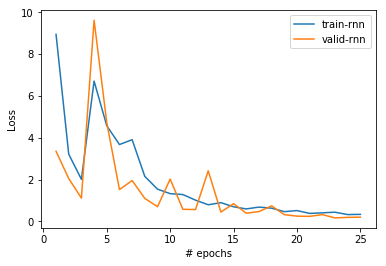

In [19]:
# Save history for later
rnn_train_loss_history = train_loss_history
rnn_valid_loss_history = valid_loss_history

# Plot training and validation curve
xaxis = range(1, n_epoch + 1)
plt.plot(xaxis, rnn_train_loss_history, label='train-rnn')
plt.plot(xaxis, rnn_valid_loss_history, label='valid-rnn')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Training an LSTM

(This cell is reproduced from the equivalent RNN one above, skip if you have read/understood that one.)

### Defining the cost and the optimizer

Recall that a cost function  $J(\theta) = L(x, y, \theta)$ takes as input a prediction and the target and evaluates some distance (or discrepancy) between both.  For this example, we will use the mean squared error cost which is standard for regression problems (see [torch.nn.MSELoss()](https://pytorch.org/docs/stable/nn.html)):

$J(\cdot) = \frac{1}{N}\sum_{i=1}^{N} (\hat{y}_{i} - y_i)^{2}$.


To optimize the parameters of our networks we will use the *stochastic gradient descent* (SGD) optimizer. It minimizes the cost function $J(\theta)$ parametrized by the networks' weights $\theta$ by updating them using the following update rule: $\theta \leftarrow \theta - \alpha \nabla J(\theta)$, where  $\alpha$ is the *learning rate*. The specificity of SGD is that ti will calculate the gradient $\nabla$ using a single (or a small number of) example(s) instead of the full training data.

In PyTorch we will use <a href="http://pytorch.org/docs/master/optim.html#torch.optim.SGD">`torch.optim.SGD()`</a> which is a SGD implementation. In this example, we will use a learning rate of 0.01.

In [20]:
# To complete
criterion = ...
optimizer = ...

### Training the model

To train out model, we will use our `train_loader` object to iterate over our entire training sets *n_epoch* times. 
To measure progress we will store the validation cost at the end of each training *epoch*.

In [21]:
# To complete

since = time.time()


train_loss_history = []
valid_loss_history = []

num_epochs = 25

model_lstm.load_state_dict(init_lstm_weights)

print("# Start training #")

for epoch in range(num_epochs):
    
    train_loss = 0
    train_n_iter = 0
    
    # Set model to train mode
    ...
    
    # Iterate over train data
    for x, y in train_loader:  

        
        # Put tensors on device (GPU when available)
        ...

        # Zero the gradient buffer
        ...
        
        # Forward
        ...
        
        # Calculate loss
        loss = criterion(...)
        
        # Backward
        ...
        
        # Optimize
        ...
        
        # Statistics
        train_loss += loss.item()
        train_n_iter += 1
    
    valid_loss = 0
    valid_n_iter = 0
    
    # Set model to evaluate mode
    ...
    
    # Iterate over valid data
    for x, y in valid_loader:  
        
        # Put tensors on device (GPU when available)
        ...
        
        # Forward
        outputs = ...
        
        loss = ...
        
        # Statistics
        valid_loss += loss.item()
        valid_n_iter += 1
    
    train_loss_history.append(train_loss / train_n_iter)
    valid_loss_history.append(valid_loss / valid_n_iter)
    
    print("Epoch {:2d} | Training loss = {:.5f} | Validation loss = {:.5f} "
          .format(epoch+1, (train_loss / train_n_iter), (valid_loss / valid_n_iter)))

time_elapsed = time.time() - since

print('\n\nTraining complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

# Start training #
Epoch  1 | Training loss = 17.85095 | Validation loss = 17.70797 
Epoch  2 | Training loss = 6.09500 | Validation loss = 1.60636 
Epoch  3 | Training loss = 1.49359 | Validation loss = 0.81062 
Epoch  4 | Training loss = 0.64184 | Validation loss = 0.26455 
Epoch  5 | Training loss = 0.47949 | Validation loss = 0.33894 
Epoch  6 | Training loss = 0.36103 | Validation loss = 0.53644 
Epoch  7 | Training loss = 0.34194 | Validation loss = 0.15094 
Epoch  8 | Training loss = 0.24848 | Validation loss = 0.30115 
Epoch  9 | Training loss = 0.21084 | Validation loss = 0.09204 
Epoch 10 | Training loss = 0.19522 | Validation loss = 0.41419 
Epoch 11 | Training loss = 0.16718 | Validation loss = 0.05944 
Epoch 12 | Training loss = 0.16016 | Validation loss = 0.05129 
Epoch 13 | Training loss = 0.14010 | Validation loss = 0.11142 
Epoch 14 | Training loss = 0.10867 | Validation loss = 0.48988 
Epoch 15 | Training loss = 0.12079 | Validation loss = 0.04461 
Epoch 16 | Training

### Visualizing training curves 

Visualize the training curves using a graph of the cost function vs. epochs for both the training and the validation data.

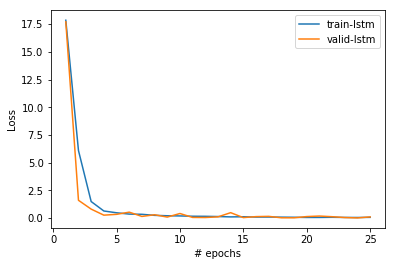

In [22]:
# Save history for later
lstm_train_loss_history = train_loss_history
lstm_valid_loss_history = valid_loss_history

# Plot training and validation curve
xaxis = range(1, num_epochs + 1)
plt.plot(xaxis, lstm_train_loss_history, label='train-lstm')
plt.plot(xaxis, lstm_valid_loss_history, label='valid-lstm')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Analyzing the results

We will now compare the RNN and the LSTM using their performance on train/validation and test sets.

### Comparing training curves


Compare the training curves using a graph of the cost function vs. epochs for both the training and the validation data.

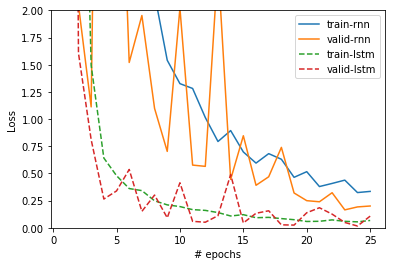

In [23]:
# Plot training and validation curve
xaxis = range(1, num_epochs + 1)

plt.plot(xaxis, rnn_train_loss_history, label='train-rnn')
plt.plot(xaxis, rnn_valid_loss_history, label='valid-rnn')

plt.plot(xaxis, lstm_train_loss_history, label='train-lstm', linestyle='--')
plt.plot(xaxis, lstm_valid_loss_history, label='valid-lstm', linestyle='--')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim([0,2])
plt.show()

Note that there is a different between the RNN and LSTM results.

**Questions**

*   Which network works best according to validation? Why is that? 
*   What is the most important different between both networks? 
*   What factors determine the smoothness of the curves? 



### Evaluating test error

Evaluate and print the mean squared error on the test set for both models.

In [27]:
# To complete

# Put data on device (GPU when available)
xtest = ...
ytest = ...

ypred_rnn = ...
ypred_lstm = ...

loss_test_rnn = ...
loss_test_lstm = ...


print("The RNN's test mean squared error is %2.3f" % float(loss_test_rnn))
print("The LSTM's trest mean squared error is %2.3f" % float(loss_test_lstm))

The RNN's test mean squared error is 0.210
The LSTM's trest mean squared error is 0.113



**Question**

*   Are test and validation results comparable? 


### Further exploring the results

To gain insights into our models we will inspect their outputs (i.e., their predictions before calculating the cost). To help us we will define a `print_sequence()` function. 

This function takes as input the tensors X and Y, samples a particular entry (sequence), prints the entry and prints the absolute difference between the true Y and the predicted Y.

Recall that we have standardized our examples. For these visualizations we wish to use the original data pre-standardization. To do so, we use `mean` + `std` such that $xtest\_unstd = xtest*std + mean$ et $ytest\_unstd = ytest*std+seq\_len*mean$.


In [32]:
def print_sequence(X, Y, idx=0):
    """Print ground truth sum and predicted values.
    Args:
      X: torch.Tensor.
      Y: torch.Tensor.
      idx: index of the sequence (entry) to use.
    """
    x = X[idx].numpy()
    y = Y[idx].numpy()
    for i, xi in enumerate(x):
        if i==0:
            string = str(xi[0]) 
        else:
            string += " + " + str(xi[0])
            
    print("Sequence: ", string)
    print("Prediction: ", str(y[0]))
    print("Ground truth value: ", str(np.sum(x)))
    diff = abs(np.sum(x)-y[0])
    print("Absolute error between X[{a}] et Y[{a}]: {b}".format(a=idx, b=diff))

In [33]:
xtest = xtest.cpu()
ypred_rnn = ypred_rnn.cpu()

# To complete
xtest_unstd = ...
ypred_unstd = ...

idx = np.random.randint(len(ytest))


print("")
print("Example RNN:")
print("")

print_sequence(xtest_unstd.detach(), ypred_unstd.detach(), idx=idx)



xtest = xtest.cpu()
ypred_lstm = ypred_lstm.cpu()

xtest_unstd = xtest*std + mean
ypred_unstd = ypred_lstm*std + seq_len*mean

print("")
print("Example LSTM:")
print("")

print_sequence(xtest_unstd.detach(), ypred_unstd.detach(), idx=idx)


Example RNN:

Sequence:  71.0 + -93.0 + 67.0 + 91.0 + -37.0 + -52.0 + -38.0 + -9.0 + -73.0 + 23.0 + 69.0 + 97.0 + -9.0 + 17.0 + 91.0 + 40.0 + 46.0 + 0.0
Prediction:  280.76157
Ground truth value:  301.0
Absolute error between X[657] et Y[657]: 20.238433837890625

Example LSTM:

Sequence:  71.0 + -93.0 + 67.0 + 91.0 + -37.0 + -52.0 + -38.0 + -9.0 + -73.0 + 23.0 + 69.0 + 97.0 + -9.0 + 17.0 + 91.0 + 40.0 + 46.0 + 0.0
Prediction:  279.6105
Ground truth value:  301.0
Absolute error between X[657] et Y[657]: 21.389495849609375


** Bonus questions**

* Can you suggest modifications to improve the results of the LSTM?
* Redo the above analysis but instead of summing the input values try other operations (e.g., -, x, /, ...)
* Compare the performance of the RNN and the LSTM for sequences of different length (i.e., change `seq_len`)

---
# Task 2: Neural language model


## Objective

The objective of the second part of the tutorial is to learn about text generation using recurrent neural networks. In particular, we will learn a recurrent neural network using a small amount of textual data written by [Shakespeare]https://en.wikipedia.org/wiki/William_Shakespeare). Once this model is trained, we will use it to generate new text in the style of Shakespeare.

**Note** that people often use the term RNN even when training an LSTM. RNN has become the generic term regardless of the type (in addition to LSTMs that are other variants that are commonly used such as [Gated Recurrent Units (GRUs)](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)).

The model we will use is a bit more complex than the one for task 1. Contrary to the previous section, all code is provided (i.e., there are no exercises to complete). We suggest you go through all of the code to ensure that you understand both its logic as it relates to text processing but also how to design and train an RNN for text generation. The code could be relatively easily adapted to other tasks that you may care about. 

Further, this notebook also contains some of the data pre-processing steps, in particular the ones that take our dataset and arranges it such that it can be used to learn a neural language model based on LSTMs.  

Happy generation!

## A bit more context to understand language modelling
(this was already covered in class)

A sequence of words $\mathbf{s}$ can be represented as a sequence of $N$ discrete symbols (or lexical tokens) such that $\mathbf{s} = (w_{1}, \dots, w_{N})$, where $w_{t}$ is a word or a punctation mark. Each symbol can be represented by an integer corresponding to its index in the vocabulary $V$. $V$ contains all symbols for a particular task (the vocabulary is usually built from the dataset we use for a task). The objective of a language model is to estimate the (joint) probability of a sequence $p(\mathbf{s}) = p(w_{1}, \dots, w_{N})$, which can be decomposed as a product of conditional probabilities such that:

\begin{equation}
  p(\mathbf{s}) = \prod^{N}_{t=1} p(w_{t} | w_{1}, \dots, w_{t-1}).
\end{equation}
(this is also known as the chain rule in probability theory)

This is important for modelling. In particular, instead of modelling the joint distribution directly, we can "simply" model each conditional. That is we can model the probability of the next word given all previous words ($p(w_{t} | w_{<t})$). Language models do just that and are widely used across numerous applications (including in automatic translation, speech recognition, and information retrieval). Note that this can be understood as a multi-class classification problem where the classes corresponds to the different words.

However, modelling each conditional is not easy. Instead we perform an approximation which makes the problem easier. The intuition behind the approximation is that instead of conditioning of the whole history we condition on a smaller history ($w_{t-1}, w_{t-2}, \ldots, w_{t-n}$) to predict the next word ($w_{t}$). This is also known as a $n-1$-order Markov assumption. Mathematically it is:
\begin{equation}
  p(w_{t} | w_{1}, \dots, w_{t-1}) \approx p(w_{t} | w_{t-n+1}, \dots, w_{t-1}).
\end{equation}

In the next paragraph we explain how to model the above conditionals using a recurrent neural network. 

The architecture of the neural language model we use is an LSTM networks which will learn at each timestep a conditional distribution of the next word using a number of previous words.
To train its parameters, we first need to set the maximum number $n-1$ of previous words to consider (`seq_len` in the code)--this is the effective size of your history--for training $p(w_{t} | w_{t-n+1}, \dots, w_{t-1})$. The input to the LSTM at each time step is: 1) the $t$'th word $w_t$ encoded using its *word embedding* (see below); 2) the recurrent state ($mathbf{h}_{t-1}$); and 3) the state of the memory at the previous timestep ($\mathbf{c}_{t-1}$).

In addition the output of the LSTM at each step is the next word $w_{t+1}$, that is we train the LSTM to predict the next word at each step (in details the LSTM will actually predict the probability of that next word). This also implies that once this model is trained we will be able to use it to generate text (we will simply pick the word with the highest probability and feed it as the input to the next step). This type of model is commonly known as an *LSTM-based neural network model*. Its architecture is shown below:

![alt-text](https://github.com/mila-iqia/dlschool-ivado-a19/blob/master/images/autoregressive_english.png?raw=true)

To compute the probability over all next words we simply use a *softmax* activation function. The softmax function returns a normalized $|V|$-dimensional vector, where each entry corresponds to a single word in the vocabulary. Each entry can be understood as the "probability" that the next word should the word at this index.

### Word Embeddings

The main question that remains is how exactly to encode the words at each timestep. 
Since the input data to a neural network must be encodable in a matrix, each symbol (word) $w_t$ in the vocabulary can be represented as a *one-hot* vector $\mathbf{x}_i$ which is a vector of zeros with a single 1 at the position of the index of this word in the vocabulary. These one-hot vectors are multiplied by a weight matrix $\mathbf{E} \in \mathbb R^{|V| \times d_{e}}$. This matrix is learned and is known as the *embedding matrix*, $\mathbf{E} \in \mathbb R^{|V| \times d_{e}}$, it effectively encodes words in a continuous representation: $\mathbf{w}_{t} \in \mathbb R^{d_{e}}$.

Using word embeddings, a sequence of words can therefore be represented a sequence of size-$N$ vectors $\mathbf{s} = (\mathbf{w}_{1}, \dots, \mathbf{w}_{N})$. Each line $i$ of this matrix $\mathbf{E}$ is a representation in $d_{e}$ dimensions of the $i$'th word in the vocabulary $V$. As we said above, these representations are often called *word embeddings*. When they are learned from a large enough dataset, they can represent semantic similarity. [For more information regarding word embeddings](http://ruder.io/word-embeddings-1/index.html).

## Utility functions for processing text and data structuring

To train our neural language model we will use a dataset (corpus) of the works of Shakespeare (we used a subset from this link [https://norvig.com/ngrams/] which was cleaned, tokenized and standardized) available in the file `shakespeare_top20K.txt`.

To obtain reasonable results in practice we should train a language model using a very-large quantity of text. In this tutorial, we will use a relatively small corpus of 20000 sentences, 159884 tokens, and a vocabulary of 12354 tokens. A token is a lexical unit separated by a whitespace on each side in the text. In our case, a token is a word, a number or a punctuation mark. The vocabulary is the set of all tokens in a corpus. (Of course, our code generalizes to larger datasets.)

In [0]:
# Clone the git repo to obtain the data
!git clone https://github.com/mila-iqia/dlschool-ivado-a19.git

Cloning into 'ecole_dl_mila_ivado_2018_10'...
remote: Enumerating objects: 214, done.
remote: Total 214 (delta 0), reused 0 (delta 0), pack-reused 214
Receiving objects: 100% (214/214), 3.78 MiB | 2.95 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [37]:
START_VOCAB = ["_UNK"]
UNK_ID = 0
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [38]:
def create_vocabulary(corpus_path, vocab_path, max_vocab_size=1e5):
    """Create and save the vocabulary of a corpus."""
    vocab = {}
    with open(corpus_path, "r", encoding="utf-8") as f:
        for line in f:
            tokens = line.strip().split()
            for token in tokens:
                if token in vocab:
                    vocab[token] += 1
                else:
                    vocab[token] = 1
    vocab_list = START_VOCAB + sorted(vocab, key=vocab.get, reverse=True)
    if len(vocab_list) > max_vocab_size:
        vocab_list = vocab_list[:max_vocab_size]
    with open(vocab_path, "w", encoding="utf-8") as f:
        for token in vocab_list:
              f.write(token + "\n")


def initialize_vocabulary(vocab_path):
    """Initialize the vocabulary."""
    if os.path.exists(vocab_path):
        with open(vocab_path, "r", encoding="utf-8") as f:
            rev_vocab = [line.strip() for line in f.readlines()]
        vocab = dict([(w, i) for (i, w) in enumerate(rev_vocab)])
        return vocab, rev_vocab
    else:
        raise ValueError("Vocabulary file {} not found.".format(vocab_path))


def read_corpus(corpus_path):
    """Read and convert a corpus in a list of tokens."""
    with open(corpus_path, "r", encoding="utf-8") as f:
        corpus = f.read().split()
    return corpus


def corpus_to_token_ids(corpus, vocab):
    """Convert a corpus in token-ids."""
    token_ids = [vocab.get(token, UNK_ID) for token in corpus]
    return token_ids


def batch_data(data, batch_size):
    """Structure the data in bath_size continuous sequences."""
    n_batch = len(data) // batch_size
    data = np.array(data[:n_batch*batch_size])
    data = data.reshape(batch_size, -1).T
    return data


def detach_hidden(hidden):
    """Transform the data from the hidden states of the LSTM
       into a new Tensor with require_grad=False."""
    return tuple(h.detach() for h in hidden)

In [56]:
# Create and initialize the vocabulary
corpus_path = "dlschool-ivado-a19/data/shakespeare_top20K.txt"
vocab_path = "vocab.txt"

create_vocabulary(corpus_path, vocab_path)
vocab, rev_vocab = initialize_vocabulary(vocab_path)

# Read the training corpus
corpus = read_corpus(corpus_path)
token_ids = corpus_to_token_ids(corpus, vocab)

# Structure the corpus in continuous sequences of batch_size for training
batch_size = 10
data = batch_data(token_ids, batch_size)
data = torch.LongTensor(data).to(DEVICE)

print("Number of tokens in the corpus: {}"
      .format(len(corpus)), end="\n\n")
print("Size of vocabulary: {}"
      .format(len(vocab)), end="\n\n")
print("Top 20 most frequent tokens in the corpus: \n{}"
      .format(rev_vocab[1:21]), end="\n\n")
print("First sentence in the corpus in text format:\n{}"
      .format(" ".join(corpus[:31])), end="\n\n")
print("First sentence in the corpus in token-id format:\n{}"
      .format(token_ids[:31]), end="\n\n")
print("Test conversaion from token-ids to text using rev_vocab:\n{}"
      .format(" ".join([rev_vocab[i] for i in token_ids[:31]])), end="\n\n")
print("Structure the training data (note that the first sentence "
      "is in the first colon):\n{}".format(data[:20]))

Number of tokens in the corpus: 159884

Size of vocabulary: 12354

Top 20 most frequent tokens in the corpus: 
[',', '.', 'the', 'I', ';', 'and', 'to', 'of', 'you', 'a', ':', 'in', '?', 'my', 'is', 'that', '!', 'not', 'it', 'me']

First sentence in the corpus in text format:
A MIDSUMMER-NIGHT'S DREAM Now , fair Hippolyta , our nuptial hour Draws on apace : four happy days bring in Another moon ; but O ! methinks how slow This old

First sentence in the corpus in token-id format:
[70, 5876, 5877, 194, 1, 143, 1948, 1, 58, 1425, 319, 4108, 46, 1949, 11, 607, 778, 608, 275, 12, 1950, 415, 5, 35, 62, 17, 1042, 119, 1115, 114, 173]

Test conversaion from token-ids to text using rev_vocab:
A MIDSUMMER-NIGHT'S DREAM Now , fair Hippolyta , our nuptial hour Draws on apace : four happy days bring in Another moon ; but O ! methinks how slow This old

Structure the training data (note that the first sentence is in the first colon):
tensor([[   70,  3426,  1967,    31,    51,     1,  4276,     4,  

In [52]:
# Split ensembles training/validation and create DataLoaders
X = data[:-1]
Y = data[1:]

n_valid = round(data.size(0) * 0.1)
train_set = TensorDataset(X[:(data.size(0)-n_valid)], Y[:(data.size(0)-n_valid)])
valid_set = TensorDataset(X[-n_valid:], Y[-n_valid:])

seq_len = 40
train_loader = DataLoader(train_set, batch_size=seq_len, shuffle=False)
valid_loader = DataLoader(valid_set, batch_size=seq_len, shuffle=False)

print("Training set: {} sequences of length {} and {} minibatches"
      .format(len(train_set), seq_len, len(train_loader)))
print("Validation set: {} sequences of length {} and {} minibatches"
      .format(len(valid_set), seq_len, len(valid_loader)))

Ensemble d'entraînement: 14389 séquences de longueur 40 et 360 minibatches
Ensemble de validation : 1599 séquences de longueur 40 et 40 minibatches


## Implementing the model

Below you will find the code of an *LSTM-based neural language model* as described in the **A bit more context to understand language modelling** Section.

At each timestep, the input variables of the LSTM are:
<ol>
    <li> a minibatch of sequences of token-ids (i.e., sequences of indices where each index represents the position of a token in the vocabulary);</li>
    <li> tuples $(\mathbf{h}_{0}, \mathbf{c}_{0})$ corresponding to recurrent states and memory states  $(\mathbf{h}_{T}, \mathbf{c}_{T})$ from the previous minibatch  (except for the first minibatch where we simply initialize these variables to 0.0 with the `init_hidden()` function).
</ol>

Each sequence of token-ids is transformed in sequences of *word embeddings* by indexing the *word embeddings* created by the class [torch.nn.Embedding()](https://pytorch.org/docs/stable/nn.html?highlight=embedding#torch.nn.Embedding) which is a matrix of parameters of dimension $|V| \times d_{e}$, where $|V|$ is the vocabulary size (`vocab_size`) and $d_{e}$ is the dimension of a *word embedding* (`embedding_size`).

We will also apply dropout on the input *word embeddings* as well as on the output layer to provide regularization.

In [57]:
class LanguageModel(nn.Module):
    """LSTM based language neural model"""
    
    def __init__(self, vocab_size, input_size, hidden_size, n_layers=1, dropout=0.5):
        """
        Args:
          vocab_size: size of the vocabulary.
          input_size: size of the word embeddings.
          hidden_size: size of the hiden states of the LSTM.
          n_layers: number of layers of the LSTM (default: 1).
          dropout: if non-zero, uses a layer of dropout at the input at at the output of 
                    the LSTM introduit une couche dropout à l'entrée et à la sortie,
                    where the input sets the value of the dropout (default: 0.5).
        """        
        super(LanguageModel, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embeddings = nn.Embedding(vocab_size, input_size)
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            n_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

        self.init_weights()

    def forward(self, input, hidden):
        embeddings = self.dropout(self.embeddings(input))
        output, hidden = self.lstm(embeddings, hidden)
        output = self.dropout(output)
        result = self.linear(output.view(output.size(0)*output.size(1), output.size(2)))
        return result.view(output.size(0), output.size(1), result.size(1)), hidden

    def init_weights(self):
        init.uniform_(self.embeddings.weight, -0.1, 0.1)
        init.xavier_uniform_(self.linear.weight, init.calculate_gain("linear"))
        init.constant_(self.linear.bias, 0)
        
    def init_hidden(self, batch_size):
        """Initialize the values of the hidden state and the LSTM cell to zero.
        Args:
          batch_size: size of a mini-batch at one time-step
          
        Returns:
          hidden: hidden state h_t and the cell c_t à t=0 initialized to 0, 
                  ((n_layers, batch_size, hidden_size),
                   (n_layers, batch_size, hidden_size)).
        """
        hidden = (torch.zeros(self.n_layers, batch_size, self.hidden_size, device=DEVICE),
                  torch.zeros(self.n_layers, batch_size, self.hidden_size, device=DEVICE))
        return hidden

## Training the model

The training procedure is very similar to the procedure used in Task 1. The key elements that differ are: 

* We use dropout on the input *word embeddings* as well as on the output layer of the LSTM. The small size of our data makes regularization important. In particular, for language models based on recurrent neural networks, we suggest using a fairly large droput value.
* We change the learning rate through training. We begin with a fairly high one (see `learning_rate`) and divide it by 10 as a function of the validation error at the end of each *epoch*. In particular we use this class:  [torch.optim.lr_scheduler.ReduceLROnPlateau()](https://pytorch.org/docs/stable/optim.html?highlight=plateau#torch.optim.lr_scheduler.ReduceLROnPlateau).
* To mitigate the problem of *exploding gradient* we use a *gradient-clipping* approach and normalize the norm of the gradient using this function [torch.nn.utils.clip_grad_norm_()](https://pytorch.org/docs/stable/nn.html?highlight=clip#torch.nn.utils.clip_grad_norm_).
* We initialize to 0.0 the values of the tuple containing the recurrent state and the hidden memory state $(\mathbf{h}_{0}, \mathbf{c}_{0})$ using the `init_hidden()` function. We do this only once at the beginning of each *epoch* and we propagate the new values of hidden through all training minibatches. In other words, the data has beeen structured using the `batch_data()` function such that we can initialize `hidden` $(\mathbf{h}_{0}, \mathbf{c}_{0})$ of each sequence of minibatch using $(\mathbf{h}_{T}, \mathbf{c}_{T})$ of the previous minibatch. Using this method implies that we cannot shuffle the order of the sequences at each training *epoch* (i.e., `train_loader = DataLoader(train_set, batch_size=seq_len, shuffle=False)`).
* Our cost function is the cross-entropy [torch.nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/nn.html?highlight=crossentropy#torch.nn.CrossEntropyLoss) which is standard for multi-class classification problems.
* We will use *[perplexity](https://en.wikipedia.org/wiki/Perplexity)* as a way to measure the quality of our model. The intuition is that a good model should not be perplex when evaluating new data. 

In [54]:
# Construct the model
vocab_size = len(vocab)
embedding_size = 300
hidden_size = 400
n_layers = 1
dropout = 0.65
model = LanguageModel(vocab_size, embedding_size, hidden_size, n_layers, dropout).to(DEVICE)
print("Number of parameters in the model:", sum(param.nelement() for param in model.parameters()))

# Cost and optimization functions
learning_rate = 10
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2, verbose=True)

# Training the model
n_epochs = 20
max_grad_norm = 1

print("Training the model for {} epochs of {} minibatches".format(n_epochs, len(train_loader)))
for epoch in range(n_epochs):
    model.train()
    hidden = model.init_hidden(batch_size)
    train_loss = 0
    valid_loss = 0
    for x, y in train_loader:
        # Separate the hidden nodes from the computational graph
        hidden = detach_hidden(hidden)
        
        # Reinitialize the gradient
        optimizer.zero_grad()
                
        # Forward pass
        y_pred, hidden = model(x, hidden)
        
        # Calculate the loss
        loss = loss_fun(y_pred.view(-1, vocab_size), y.view(-1))
        
        # Calculate the gradient
        loss.backward()
        
        # Normalise the gradient to prevent gradient expoding
        nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        
        # Update model parameters
        optimizer.step()        
        
        # Accumulate total loss
        train_loss += len(x) * loss.item()
    
    # Eval the model using the validation set
    model.eval()
    with torch.no_grad():
        hidden = model.init_hidden(batch_size)
        for x, y in valid_loader:
            y_pred, hidden = model(x, hidden)
            loss = loss_fun(y_pred.view(-1, vocab_size), y.view(-1))
            valid_loss += len(x) * loss.item()
    
    train_loss /= len(train_loader.dataset)
    valid_loss /= len(valid_loader.dataset)
    scheduler.step(valid_loss)

    print("Epoch {:2d} | Training loss = {:.5f} | Validation loss = {:.5f} | Perplexity = {:.2f}"
          .format(epoch+1, train_loss, valid_loss, np.exp(valid_loss)))
print("Congratulations! You have now trained a neural language model!")

Nombre de paramètres dans le modèle: 9783354
Entraînement du modèle pour 20 epochs de 360 minibatches
Epoch  1 | Training loss = 6.74751 | Validation loss = 5.92905 | Perplexity = 375.80
Epoch  2 | Training loss = 5.98986 | Validation loss = 5.73647 | Perplexity = 309.97
Epoch  3 | Training loss = 5.77130 | Validation loss = 5.58605 | Perplexity = 266.68
Epoch  4 | Training loss = 5.63721 | Validation loss = 5.52013 | Perplexity = 249.67
Epoch  5 | Training loss = 5.53869 | Validation loss = 5.46346 | Perplexity = 235.91
Epoch  6 | Training loss = 5.45660 | Validation loss = 5.41640 | Perplexity = 225.07
Epoch  7 | Training loss = 5.37894 | Validation loss = 5.40622 | Perplexity = 222.79
Epoch  8 | Training loss = 5.31645 | Validation loss = 5.37788 | Perplexity = 216.56
Epoch  9 | Training loss = 5.25550 | Validation loss = 5.38792 | Perplexity = 218.75
Epoch 10 | Training loss = 5.19939 | Validation loss = 5.36753 | Perplexity = 214.33
Epoch 11 | Training loss = 5.14271 | Validation 

## Text generation

Now that we have trained a language model, we can use it to generate text as Shakespeare! 
To do so, we will randomly select the first word (i.e., a token in a vocabulary) and use that as the input token at timestep one. We will then use the output token at the first timestep as the input token at the second timestep and son on. In total we will generate `n_words`. The `smoothing` variable allows one to obtain change the diversity of the generated text. A higher value generate more diverse but often lower quality text.

In [61]:
# Generating sequences of words
model.eval()
x = torch.randint(0, vocab_size, (1, 1), dtype=torch.long, device=DEVICE)
words = [rev_vocab[x]]
n_words = 300
smoothing = 0.5
with torch.no_grad(): 
    hidden = model.init_hidden(1)
    for i in range(n_words-1):
        output, hidden = model(x, hidden)
        weights = output.squeeze().div(smoothing).exp()
        word_idx = torch.multinomial(weights, 1)
        x.fill_(word_idx.squeeze())
        word = rev_vocab[word_idx]
        words.append(word)
        if (i+1) % 15 == 0:
            words.append("\n")
print(" ".join(words))

woman in this time , And , by the heart , that I have heard . 
 I am not a man . I say , and I will tell you . 
 I am a fool , sir . I will do you , sir , I 
 will entreat you . Come , sir , I am a woman . You shall 
 have a simple word , sir ; but I am a poor man , and 
 his mother is a good lady . I beseech you , sir , I know 
 not . And , I will tell you , sir , we are no more 
 . You shall not be a good word . I am no more . You 
 have been a courtier , sir , as I have a good friend , and 
 you do not know , To say , what you shall not be so , 
 and my good lady , I charge you , sir , I will not be 
 found to be a very good friend . I will not be a bawd , 
 sir ; but I will tell you , for that , as I have heard 
 him a word with her , as I have heard of your estate . I 
 will not do some man no harm . But I am going to be a 
 man of the forest , is the thing that I have , sir , I 
 do not know you shall be a poor fellow . I would not were it 
 with a maid . I am yours , I am sure y

What do you think of this generated text? What is remarkable is that many short sequences of words seem plausible. Longer phrases, however, usually do not make much sense. 

We note that both commas `,` and periods `.` appear very often in this generated text. This can be explain by the fact that they are the most frequent tokens in our (training) dataset. 

To obtain higher-quality texte would require training with a larger corpus. Further, the vocabulary and the style of Shakespeare may not be easiest to learn from. 

---
## References
http://karpathy.github.io/2015/05/21/rnn-effectiveness/

https://arxiv.org/abs/1803.08240